### Import Packages

In [1]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import numpy as np
import torchsummary
from alive_progress import alive_bar

### Global attributes

In [2]:
mixed_dir = {
    'machine': '../machine/mixed/',
    'nature': '../nature/mixed/',
    'human': '../human/mixed/'
}

clean_dir = {
    'machine': '../machine/clean/',
    'nature': '../nature/clean/',
    'human': '../human/clean/'
}

# TODO
test_dir = {
    'input': '../test_data/',
    'output': '../test_output/general/',
    'visual': '../visualization/general/'
}

### SNR

In [3]:
def calculate_snr(clean_signal, denoised_signal):
    """
    Calculate the Signal-to-Noise Ratio (SNR) in decibels.
    
    Args:
    clean_signal (torch.Tensor): Ground truth clean signal, shape (1, 1, H, W)
    denoised_signal (torch.Tensor): Model's output signal, shape (1, 1, H, W)
    
    Returns:
    float: SNR value in decibels.
    """
    assert clean_signal.shape == denoised_signal.shape, "Shapes of input tensors must match."
    clean_signal = clean_signal.squeeze()
    denoised_signal = denoised_signal.squeeze()
    signal_power = torch.mean(clean_signal ** 2)
    noise_power = torch.mean((clean_signal - denoised_signal) ** 2)
    if noise_power == 0:
        return float('inf')
    snr = 10 * torch.log10(signal_power / noise_power)
    return snr.item()

### Preprocess Data

In [4]:
# MelSpectrogram參數
n_mels = 128                # 保持 Mel 頻譜圖的解析度
n_fft = 1024                # 提高 FFT 窗口大小以適配更多信號頻率
hop_length = 512            # 保持 hop_length 為 n_fft 的一半
win_length = 1024           # 窗口大小與 n_fft 保持一致（或設為 None 使用默認值）
sample_rate = 16000         # 採樣率保持不變，適合語音處理
f_max = sample_rate // 2    # 預設為 Nyquist 頻率，即 8000 Hz
duration = 5                # 音頻時長為 5 秒

In [5]:
def load_spectrogram_from_npy(mixed_dir, clean_dir = None):
    """Load mel spectrogram from a NumPy file."""
    mixed_mel_spectrograms = []
    clean_mel_spectrograms = []
    
    length = len(os.listdir(mixed_dir))
    
    print(f"Loading {length} files...")

    with alive_bar(length, force_tty=True) as bar:
        for filename in sorted(os.listdir(mixed_dir)):
            if ".gitkeep" in filename:
                continue
            try:
                # 使用完整路徑
                mixed_path = os.path.join(mixed_dir, filename)
                if (clean_dir != None): clean_path = os.path.join(clean_dir, filename)
                
                mixed_mel_spectrogram_db = np.load(mixed_path)
                if (clean_dir != None): clean_mel_spectrogram_db = np.load(clean_path)

                # # 轉換為 PyTorch tensor 並添加通道維度
                mixed_mel_tensor = torch.tensor(mixed_mel_spectrogram_db, dtype=torch.float32).squeeze().unsqueeze(0)
                if (clean_dir != None): clean_mel_tensor = torch.tensor(clean_mel_spectrogram_db, dtype=torch.float32).squeeze().unsqueeze(0)
                
                mixed_mel_spectrograms.append(mixed_mel_tensor)
                if (clean_dir != None): clean_mel_spectrograms.append(clean_mel_tensor)
                
                bar()
                
            except Exception as e:
                print(f"Error load file {filename}: {str(e)}")
                continue

    if (clean_dir != None): return mixed_mel_spectrograms, clean_mel_spectrograms
    else: return mixed_mel_spectrograms

In [6]:
# TODO
machine_mixed_mel_spectrograms, machine_clean_mel_spectrograms = load_spectrogram_from_npy(mixed_dir['machine'], clean_dir['machine'])
nature_mixed_mel_spectrograms, nature_clean_mel_spectrograms = load_spectrogram_from_npy(mixed_dir['nature'], clean_dir['nature'])
human_mixed_mel_spectrograms, human_clean_mel_spectrograms = load_spectrogram_from_npy(mixed_dir['human'], clean_dir['human'])
test_mixed_mel_spectrograms = load_spectrogram_from_npy(test_dir['input'])
mixed_mel_spectrograms = machine_mixed_mel_spectrograms + nature_mixed_mel_spectrograms + human_mixed_mel_spectrograms
clean_mel_spectrograms = machine_clean_mel_spectrograms + nature_clean_mel_spectrograms + human_clean_mel_spectrograms
target_dim = 160
pad_width = [(0, 0), (0, 0), (0, target_dim - mixed_mel_spectrograms[0].shape[2])]
mixed_mel_spectrograms = [np.pad(i, pad_width=pad_width, mode='constant', constant_values=0) for i in mixed_mel_spectrograms]
clean_mel_spectrograms = [np.pad(i, pad_width=pad_width, mode='constant', constant_values=0) for i in clean_mel_spectrograms]
test_mixed_mel_spectrograms = [np.pad(i, pad_width=pad_width, mode='constant', constant_values=0) for i in test_mixed_mel_spectrograms]
mixed_mel_spectrograms_train, mixed_mel_spectrograms_val, clean_mel_spectrograms_train, clean_mel_spectrograms_val = train_test_split(mixed_mel_spectrograms, clean_mel_spectrograms, test_size=0.2, random_state=42)
time_steps = mixed_mel_spectrograms[0].shape[2]

Loading 7500 files...
|████████████████████████████████████████| 7500/7500 [100%] in 1:10.3 (106.71/s) ▅▃▁ 2203/7500 [29%] in 9s (~21s, 256. ▇▅▃ 2350/7500 [31%] in 11s (~24s, 211 ▂▄▆ 2468/7500 [33%] in 13s (~26s, 193 ▃▅▇ 2472/7500 [33%] in 13s (~26s, 192 █▆▄ 2487/7500 [33%] in 13s (~26s, 190 ▇▅▃ 3028/7500 [40%] in 22s (~32s, 140 ▃▁▃ 4641/7500 [62%] in 43s (~26s, 108
Loading 7500 files...
|████████████████████████████████████████| 7500/7500 [100%] in 3.3s (2266.45/s)  ▄▆█ 403/7500 [5%] in 0s (~3s, 2364.0/ ▂▄▆ 1302/7500 [17%] in 1s (~3s, 2333. ▅▃▁ 3087/7500 [41%] in 1s (~2s, 2387. ▄▆█ 3524/7500 [47%] in 2s (~2s, 2332. ▇▅▃ 4935/7500 [66%] in 2s (~1s, 2327. ▂▄▆ 5399/7500 [72%] in 2s (~1s, 2315. ▇▅▃ 5861/7500 [78%] in 3s (~1s, 2307.
Loading 7500 files...
|████████████████████████████████████████| 7500/7500 [100%] in 3.1s (2423.81/s)  ▅▃▁ 2025/7500 [27%] in 1s (~2s, 2401. ▂▂▄ 2259/7500 [30%] in 1s (~2s, 2407. ▃▅▇ 3606/7500 [48%] in 1s (~2s, 2428. ▆▄▂ 5226/7500 [70%] in 2s (~1s, 2439. ▁▃▅ 560

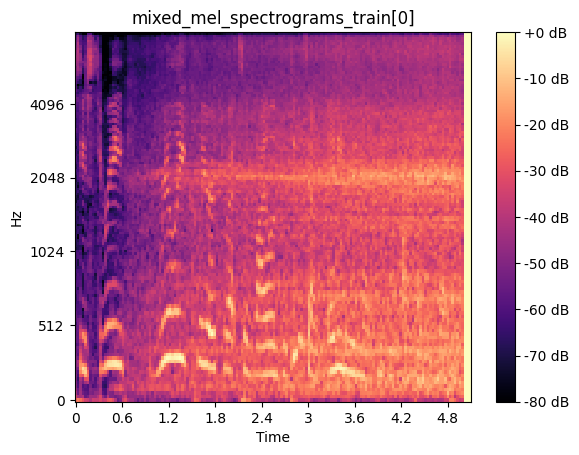

In [7]:
fig, ax = plt.subplots()
img = librosa.display.specshow(mixed_mel_spectrograms_train[0][0], sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='mixed_mel_spectrograms_train[0]')
plt.show()

# 將圖像保存至檔案
output_path = test_dir['visual'] + "mixed_mel_spectrograms_train[0].png"  # 定義保存的檔案名稱和格式
fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
plt.close(fig)  # 避免顯示圖像（若不需要可保留 plt.show()）

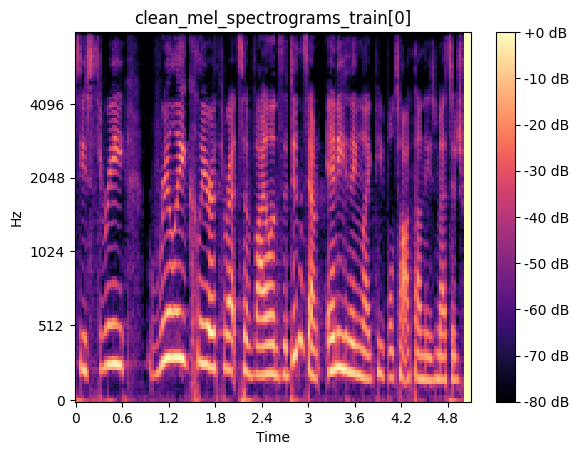

In [8]:
fig, ax = plt.subplots()
img = librosa.display.specshow(clean_mel_spectrograms_train[0][0], sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='clean_mel_spectrograms_train[0]')
plt.show()

# 將圖像保存至檔案
output_path = test_dir['visual'] + "clean_mel_spectrograms_train[0].png"  # 定義保存的檔案名稱和格式
fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
plt.close(fig)  # 避免顯示圖像（若不需要可保留 plt.show()）

### Training

In [9]:
class DenoiseAutoencoder(nn.Module):
    def __init__(self):
        super(DenoiseAutoencoder, self).__init__()
        # 編碼器
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # 全連接層 ### shape 有問題
        self.fc1 = nn.Linear(10240, 256)  # 假設輸入大小為 (1, 64, 64)
        self.fc2 = nn.Linear(256, 10240)

        # 解碼器
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(1),
        )

    def forward(self, x):
        # 編碼器
        x = self.encoder(x)
        
        # 將特徵展平
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        
        # 全連接層處理
        x = self.fc1(x)
        x = self.fc2(x)
        
        # 恢復形狀為解碼器輸入
        x = x.view(batch_size, 128, 8, 10)
        # 解碼器
        x = self.decoder(x)
        return x

In [10]:
# Model參數
num_epochs = 100
batch_size = 256
learning_rate = 0.5
lr_decay_step = 20
lr_decay_gamma = 0.7

In [11]:
class AudioDataset(Dataset):
    def __init__(self, mixed_data, clean_data):
        self.mixed = mixed_data
        self.clean = clean_data
    
    def __len__(self):
        return len(self.mixed)
    
    def __getitem__(self, idx):
        return self.mixed[idx], self.clean[idx]

dataset = AudioDataset(mixed_mel_spectrograms_train, clean_mel_spectrograms_train)
dataloader = DataLoader(dataset, batch_size=batch_size)
dataloader_val = DataLoader(AudioDataset(mixed_mel_spectrograms_val, clean_mel_spectrograms_val), batch_size=len(mixed_mel_spectrograms_val))


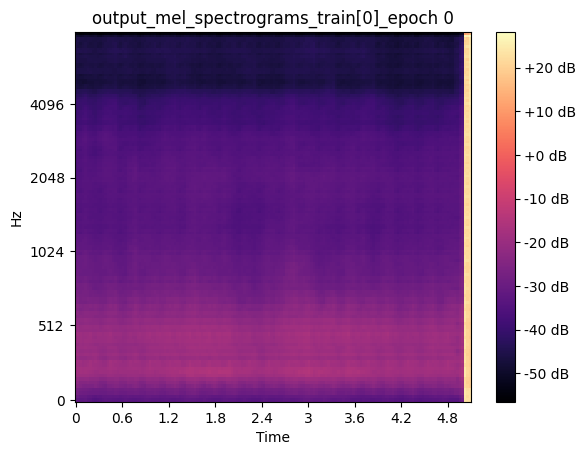

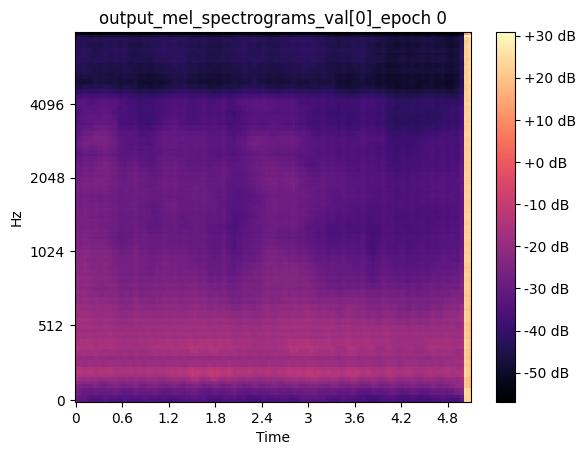

Epoch [1/100], Training Loss: 687.792358398438, Validation Loss: 586.840515136719, Learning Rate: 0.50000000
Epoch [2/100], Training Loss: 175.810745239258, Validation Loss: 154.632431030273, Learning Rate: 0.50000000
Epoch [3/100], Training Loss: 99.643440246582, Validation Loss: 104.727371215820, Learning Rate: 0.50000000
Epoch [4/100], Training Loss: 57.846961975098, Validation Loss: 72.491104125977, Learning Rate: 0.50000000
Epoch [5/100], Training Loss: 40.257705688477, Validation Loss: 50.657314300537, Learning Rate: 0.50000000
Epoch [6/100], Training Loss: 31.609233856201, Validation Loss: 42.852981567383, Learning Rate: 0.50000000
Epoch [7/100], Training Loss: 26.268486022949, Validation Loss: 38.618862152100, Learning Rate: 0.50000000
Epoch [8/100], Training Loss: 22.732271194458, Validation Loss: 34.542797088623, Learning Rate: 0.50000000
Epoch [9/100], Training Loss: 20.465560913086, Validation Loss: 32.237449645996, Learning Rate: 0.50000000
Epoch [10/100], Training Loss: 1

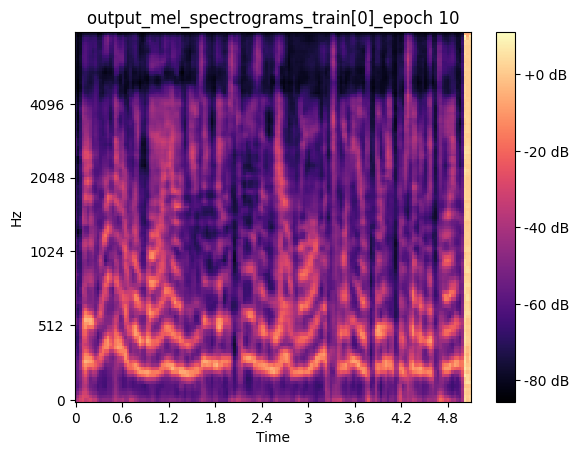

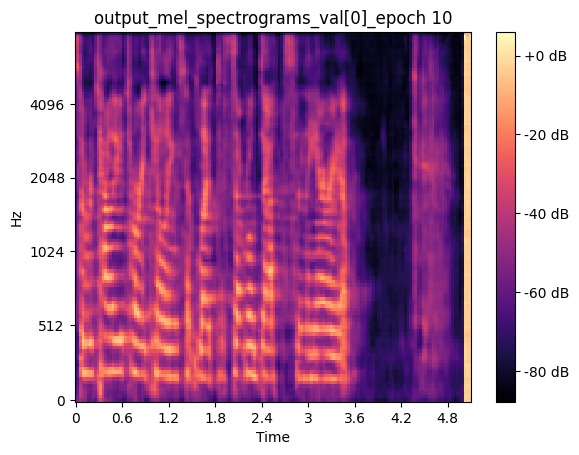

Epoch [11/100], Training Loss: 17.672412872314, Validation Loss: 29.647989273071, Learning Rate: 0.50000000
Epoch [12/100], Training Loss: 16.363842010498, Validation Loss: 28.737558364868, Learning Rate: 0.50000000
Epoch [13/100], Training Loss: 15.524580001831, Validation Loss: 26.958364486694, Learning Rate: 0.50000000
Epoch [14/100], Training Loss: 14.998398780823, Validation Loss: 26.318675994873, Learning Rate: 0.50000000
Epoch [15/100], Training Loss: 14.178679466248, Validation Loss: 26.028636932373, Learning Rate: 0.50000000
Epoch [16/100], Training Loss: 13.752322196960, Validation Loss: 25.148614883423, Learning Rate: 0.50000000
Epoch [17/100], Training Loss: 13.391047477722, Validation Loss: 24.016826629639, Learning Rate: 0.50000000
Epoch [18/100], Training Loss: 12.903255462646, Validation Loss: 23.364410400391, Learning Rate: 0.50000000
Epoch [19/100], Training Loss: 12.556726455688, Validation Loss: 22.885562896729, Learning Rate: 0.50000000
Epoch [20/100], Training Los

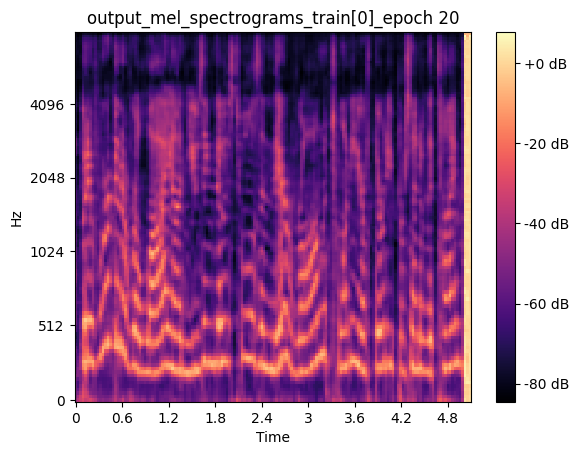

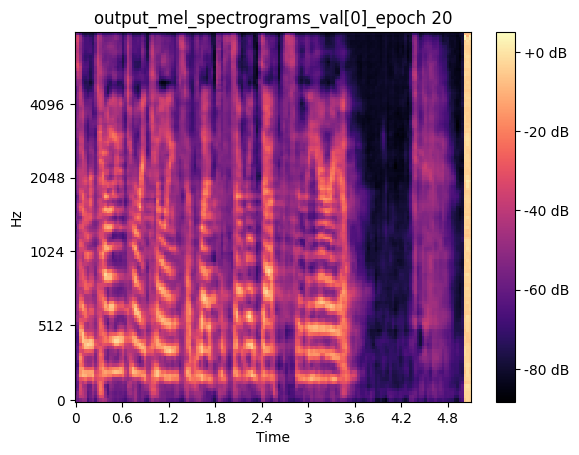

Epoch [21/100], Training Loss: 11.986832618713, Validation Loss: 22.417167663574, Learning Rate: 0.35000000
Epoch [22/100], Training Loss: 11.772093772888, Validation Loss: 22.372564315796, Learning Rate: 0.35000000
Epoch [23/100], Training Loss: 11.529511451721, Validation Loss: 22.275636672974, Learning Rate: 0.35000000
Epoch [24/100], Training Loss: 11.308269500732, Validation Loss: 22.180501937866, Learning Rate: 0.35000000
Epoch [25/100], Training Loss: 11.081384658813, Validation Loss: 22.122482299805, Learning Rate: 0.35000000
Epoch [26/100], Training Loss: 10.916020393372, Validation Loss: 22.088174819946, Learning Rate: 0.35000000
Epoch [27/100], Training Loss: 10.767099380493, Validation Loss: 22.141645431519, Learning Rate: 0.35000000
Epoch [28/100], Training Loss: 10.638106346130, Validation Loss: 22.146940231323, Learning Rate: 0.35000000
Epoch [29/100], Training Loss: 10.513027191162, Validation Loss: 22.139863967896, Learning Rate: 0.35000000
Epoch [30/100], Training Los

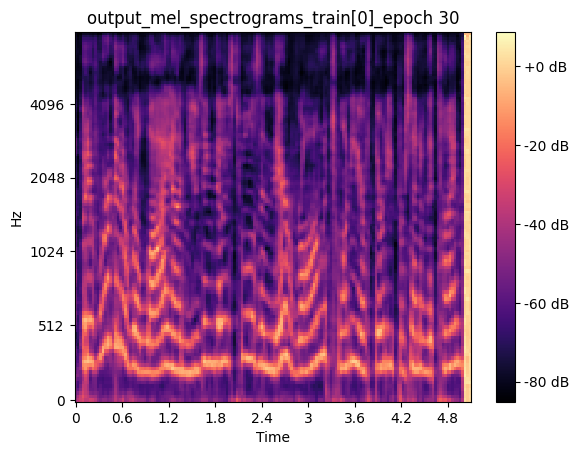

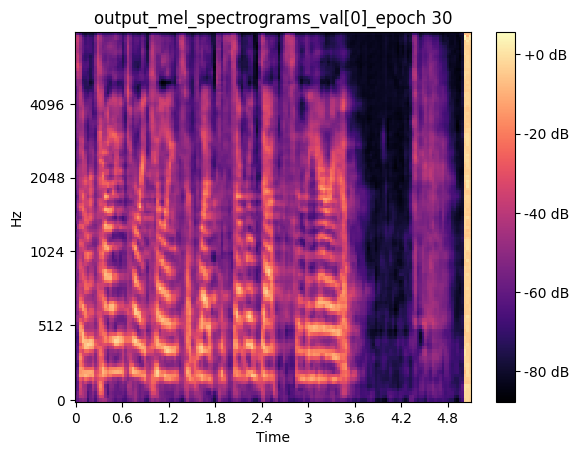

Epoch [31/100], Training Loss: 10.259235382080, Validation Loss: 22.092987060547, Learning Rate: 0.35000000
Epoch [32/100], Training Loss: 10.135271072388, Validation Loss: 22.115684509277, Learning Rate: 0.35000000
Epoch [33/100], Training Loss: 10.012421607971, Validation Loss: 22.015794754028, Learning Rate: 0.35000000
Epoch [34/100], Training Loss: 9.911324501038, Validation Loss: 21.895120620728, Learning Rate: 0.35000000
Epoch [35/100], Training Loss: 9.798750877380, Validation Loss: 21.899080276489, Learning Rate: 0.35000000
Epoch [36/100], Training Loss: 9.725083351135, Validation Loss: 21.619318008423, Learning Rate: 0.35000000
Epoch [37/100], Training Loss: 9.578037261963, Validation Loss: 21.510841369629, Learning Rate: 0.35000000
Epoch [38/100], Training Loss: 9.474400520325, Validation Loss: 21.101917266846, Learning Rate: 0.35000000
Epoch [39/100], Training Loss: 9.401920318604, Validation Loss: 20.996311187744, Learning Rate: 0.35000000
Epoch [40/100], Training Loss: 9.2

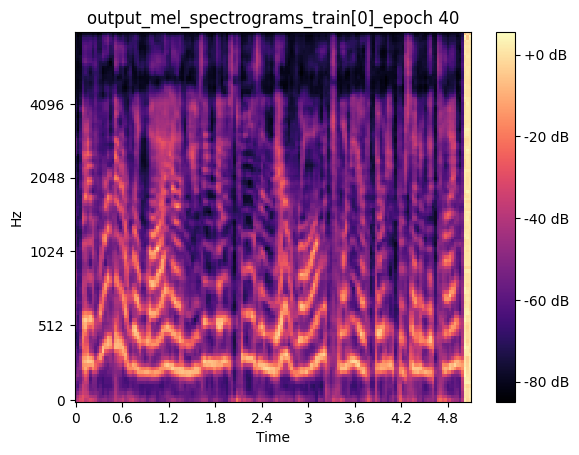

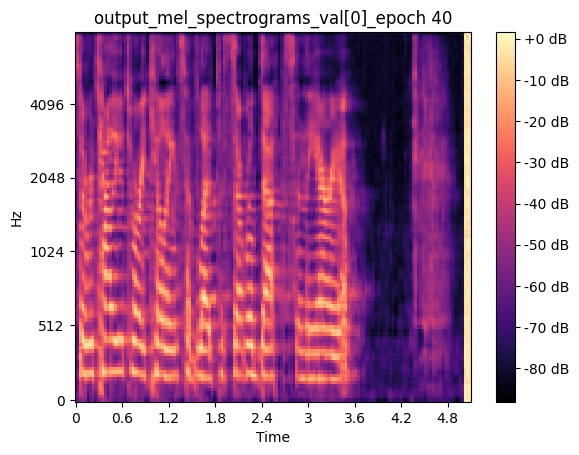

Epoch [41/100], Training Loss: 9.333016395569, Validation Loss: 21.108806610107, Learning Rate: 0.24500000
Epoch [42/100], Training Loss: 9.223883628845, Validation Loss: 20.802928924561, Learning Rate: 0.24500000
Epoch [43/100], Training Loss: 9.089083671570, Validation Loss: 20.695621490479, Learning Rate: 0.24500000
Epoch [44/100], Training Loss: 9.000436782837, Validation Loss: 20.774427413940, Learning Rate: 0.24500000
Epoch [45/100], Training Loss: 8.949704170227, Validation Loss: 20.793384552002, Learning Rate: 0.24500000
Epoch [46/100], Training Loss: 8.885300636292, Validation Loss: 20.767023086548, Learning Rate: 0.24500000
Epoch [47/100], Training Loss: 8.825336456299, Validation Loss: 20.903778076172, Learning Rate: 0.24500000
Epoch [48/100], Training Loss: 8.814990997314, Validation Loss: 21.186038970947, Learning Rate: 0.24500000
Epoch [49/100], Training Loss: 8.744206428528, Validation Loss: 21.111591339111, Learning Rate: 0.24500000
Epoch [50/100], Training Loss: 8.7349

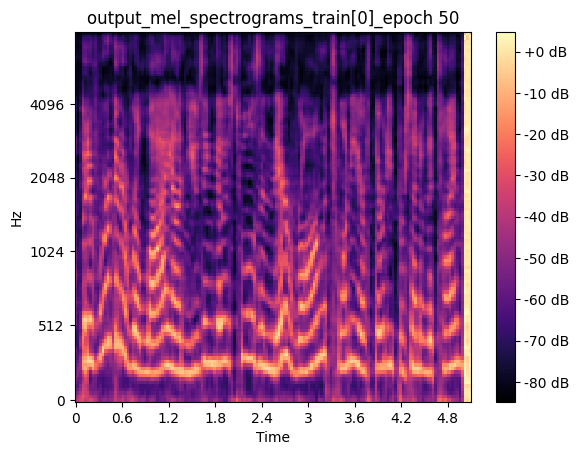

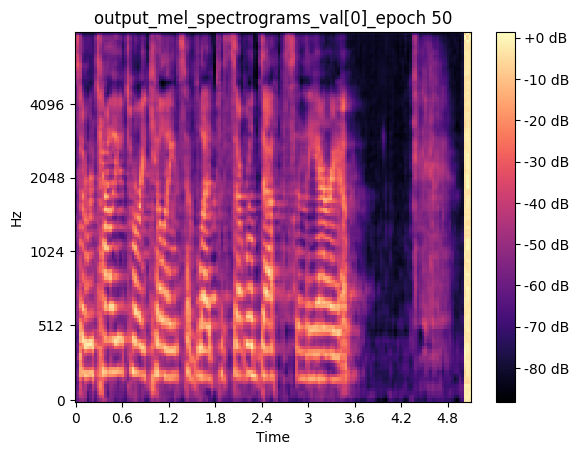

Epoch [51/100], Training Loss: 8.660863876343, Validation Loss: 20.801765441895, Learning Rate: 0.24500000
Epoch [52/100], Training Loss: 8.667995452881, Validation Loss: 20.855495452881, Learning Rate: 0.24500000
Epoch [53/100], Training Loss: 8.586585998535, Validation Loss: 20.985000610352, Learning Rate: 0.24500000
Epoch [54/100], Training Loss: 8.479952812195, Validation Loss: 20.967298507690, Learning Rate: 0.24500000
Epoch [55/100], Training Loss: 8.361323356628, Validation Loss: 20.868907928467, Learning Rate: 0.24500000
Epoch [56/100], Training Loss: 8.279533386230, Validation Loss: 20.890195846558, Learning Rate: 0.24500000
Epoch [57/100], Training Loss: 8.211800575256, Validation Loss: 20.732130050659, Learning Rate: 0.24500000
Epoch [58/100], Training Loss: 8.157215118408, Validation Loss: 20.486003875732, Learning Rate: 0.24500000
Epoch [59/100], Training Loss: 8.090367317200, Validation Loss: 20.306707382202, Learning Rate: 0.24500000
Epoch [60/100], Training Loss: 8.0357

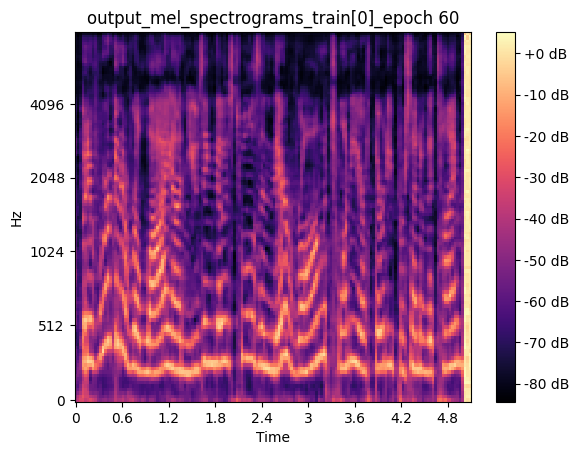

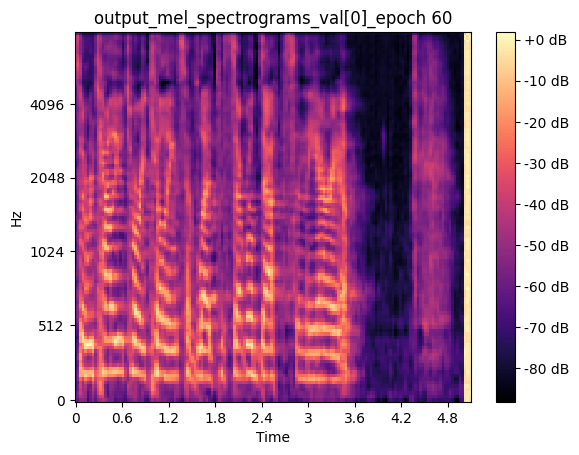

Epoch [61/100], Training Loss: 7.933836460114, Validation Loss: 20.531499862671, Learning Rate: 0.17150000
Epoch [62/100], Training Loss: 7.836688995361, Validation Loss: 20.273212432861, Learning Rate: 0.17150000
Epoch [63/100], Training Loss: 7.778943061829, Validation Loss: 20.205966949463, Learning Rate: 0.17150000
Epoch [64/100], Training Loss: 7.750643253326, Validation Loss: 20.195413589478, Learning Rate: 0.17150000
Epoch [65/100], Training Loss: 7.709025859833, Validation Loss: 20.218776702881, Learning Rate: 0.17150000
Epoch [66/100], Training Loss: 7.657033920288, Validation Loss: 20.275478363037, Learning Rate: 0.17150000
Epoch [67/100], Training Loss: 7.619892597198, Validation Loss: 20.236072540283, Learning Rate: 0.17150000
Epoch [68/100], Training Loss: 7.580102920532, Validation Loss: 20.159204483032, Learning Rate: 0.17150000
Epoch [69/100], Training Loss: 7.543777942657, Validation Loss: 20.045259475708, Learning Rate: 0.17150000
Epoch [70/100], Training Loss: 7.4956

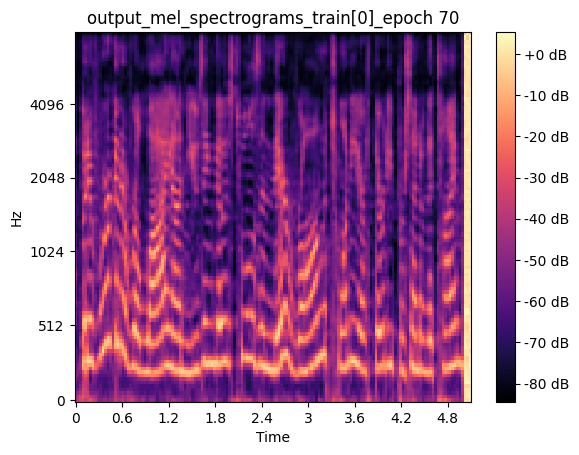

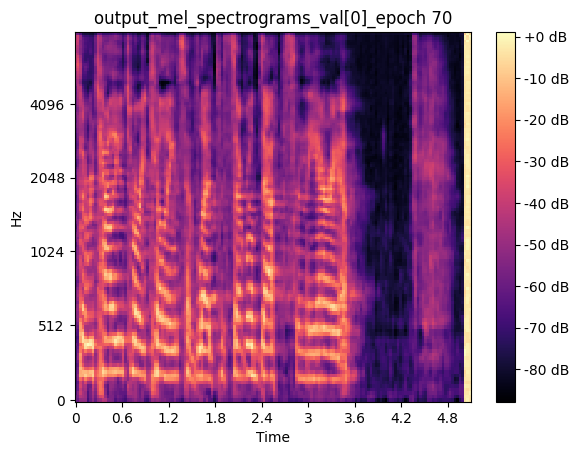

Epoch [71/100], Training Loss: 7.452857494354, Validation Loss: 19.791057586670, Learning Rate: 0.17150000
Epoch [72/100], Training Loss: 7.413796901703, Validation Loss: 19.655368804932, Learning Rate: 0.17150000
Epoch [73/100], Training Loss: 7.381770133972, Validation Loss: 19.513553619385, Learning Rate: 0.17150000
Epoch [74/100], Training Loss: 7.354773998260, Validation Loss: 19.452045440674, Learning Rate: 0.17150000
Epoch [75/100], Training Loss: 7.313409328461, Validation Loss: 19.362922668457, Learning Rate: 0.17150000
Epoch [76/100], Training Loss: 7.273222446442, Validation Loss: 19.267210006714, Learning Rate: 0.17150000
Epoch [77/100], Training Loss: 7.235513210297, Validation Loss: 19.234233856201, Learning Rate: 0.17150000
Epoch [78/100], Training Loss: 7.197993278503, Validation Loss: 19.232517242432, Learning Rate: 0.17150000
Epoch [79/100], Training Loss: 7.172685623169, Validation Loss: 19.114633560181, Learning Rate: 0.17150000
Epoch [80/100], Training Loss: 7.1626

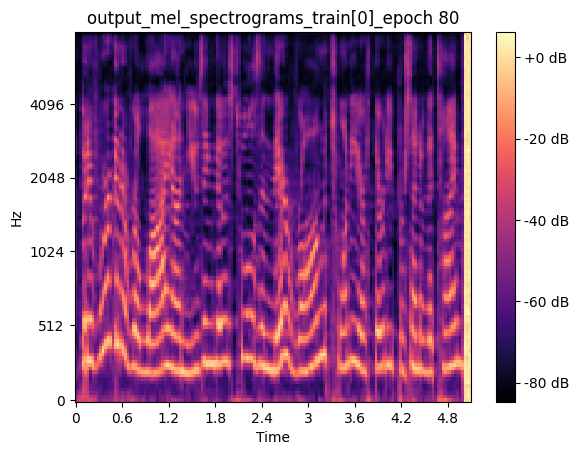

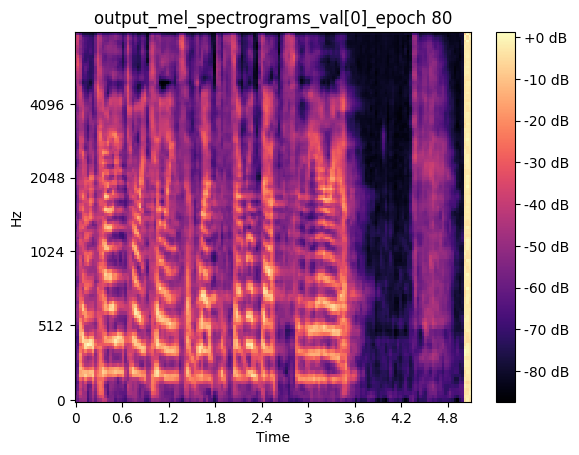

Epoch [81/100], Training Loss: 7.149685859680, Validation Loss: 19.160926818848, Learning Rate: 0.12005000
Epoch [82/100], Training Loss: 7.078811168671, Validation Loss: 19.295837402344, Learning Rate: 0.12005000
Epoch [83/100], Training Loss: 7.032110214233, Validation Loss: 19.353839874268, Learning Rate: 0.12005000
Epoch [84/100], Training Loss: 6.995298385620, Validation Loss: 19.357252120972, Learning Rate: 0.12005000
Epoch [85/100], Training Loss: 6.969964027405, Validation Loss: 19.395236968994, Learning Rate: 0.12005000
Epoch [86/100], Training Loss: 6.944711685181, Validation Loss: 19.449523925781, Learning Rate: 0.12005000
Epoch [87/100], Training Loss: 6.923878669739, Validation Loss: 19.495189666748, Learning Rate: 0.12005000
Epoch [88/100], Training Loss: 6.895588874817, Validation Loss: 19.574867248535, Learning Rate: 0.12005000
Epoch [89/100], Training Loss: 6.852711200714, Validation Loss: 19.687202453613, Learning Rate: 0.12005000
Epoch [90/100], Training Loss: 6.8085

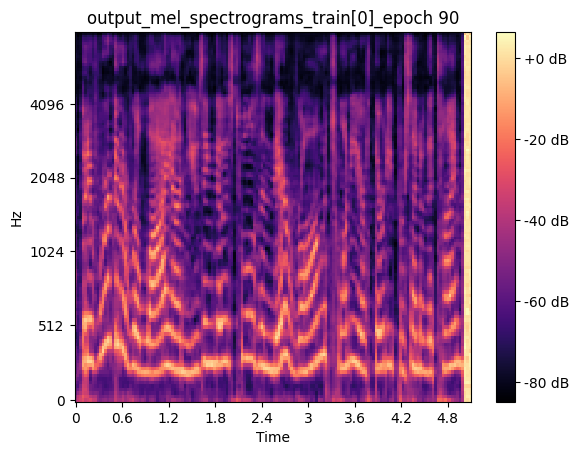

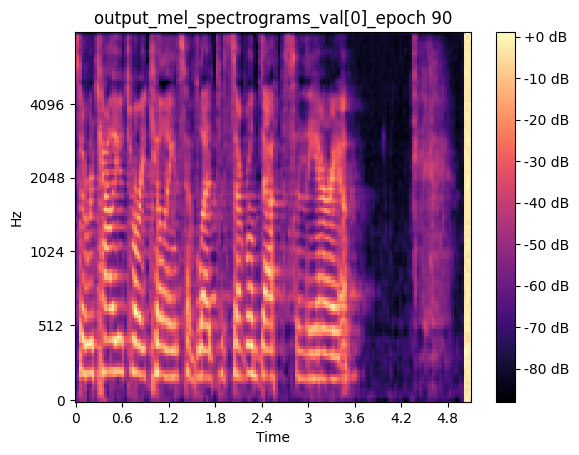

Epoch [91/100], Training Loss: 6.780031681061, Validation Loss: 19.630920410156, Learning Rate: 0.12005000
Epoch [92/100], Training Loss: 6.763610363007, Validation Loss: 19.570871353149, Learning Rate: 0.12005000
Epoch [93/100], Training Loss: 6.738384246826, Validation Loss: 19.542430877686, Learning Rate: 0.12005000
Epoch [94/100], Training Loss: 6.724628925323, Validation Loss: 19.534519195557, Learning Rate: 0.12005000
Epoch [95/100], Training Loss: 6.708028793335, Validation Loss: 19.583850860596, Learning Rate: 0.12005000
Epoch [96/100], Training Loss: 6.698190689087, Validation Loss: 19.501712799072, Learning Rate: 0.12005000
Epoch [97/100], Training Loss: 6.670361518860, Validation Loss: 19.467803955078, Learning Rate: 0.12005000
Epoch [98/100], Training Loss: 6.651055812836, Validation Loss: 19.407360076904, Learning Rate: 0.12005000
Epoch [99/100], Training Loss: 6.639649868011, Validation Loss: 19.392786026001, Learning Rate: 0.12005000
Epoch [100/100], Training Loss: 6.629

In [12]:
from torch.optim.lr_scheduler import StepLR
import gc
model = DenoiseAutoencoder()

# torchsummary.summary(model,(1,64,44))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=lr_decay_step, gamma=lr_decay_gamma)
training_losses = []
validation_losses = []
training_snrs = []
validation_snrs = []
train_input = torch.tensor(np.array([mixed_mel_spectrograms_train[0]]), dtype=torch.float32)
train_clean = torch.tensor(np.array([clean_mel_spectrograms_train[0]]), dtype=torch.float32)
val_input = torch.tensor(np.array([mixed_mel_spectrograms_val[0]]), dtype=torch.float32)
val_clean = torch.tensor(np.array([clean_mel_spectrograms_val[0]]), dtype=torch.float32)

# 訓練過程
for epoch in range(num_epochs):
    model.train()
    sum_loss = 0
    for (mixed, clean) in dataloader:
        
        optimizer.zero_grad()

        # 前向傳播
        outputs = model(mixed)
        loss = criterion(outputs, clean)
        sum_loss += loss.item()
            
        # 反向傳播和優化
        loss.backward()
        optimizer.step()
        
    # Step the scheduler to decay the learning rate
    scheduler.step()
    
    # count training loss and SNR
    snr = calculate_snr(clean, outputs)
    training_losses.append(sum_loss / len(dataloader))
    training_snrs.append(snr)
    
    if epoch % 10 == 0:
        fig, ax = plt.subplots()
        img = librosa.display.specshow(outputs[0][0].detach().cpu().numpy(), sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        ax.set(title=f'output_mel_spectrograms_train[0]_epoch {epoch}')
        plt.show()

        # 將圖像保存至檔案
        output_path = test_dir['visual'] + f'output_mel_spectrograms_train[0]_epoch {epoch}'  # 定義保存的檔案名稱和格式
        fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
        plt.close(fig)  # 避免顯示圖像 (若不需要可保留 plt.show())
        gc.collect()
    
    # count validation loss and SNR
    val_output = model(val_input)
    val_loss = criterion(val_output, val_clean)
    val_snr = calculate_snr(val_clean, val_output)
    validation_losses.append(val_loss.item())
    validation_snrs.append(val_snr)
    
    if epoch % 10 == 0:
        fig, ax = plt.subplots()
        img = librosa.display.specshow(val_output[0][0].detach().cpu().numpy(), sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        ax.set(title=f'output_mel_spectrograms_val[0]_epoch {epoch}')
        plt.show()

        # 將圖像保存至檔案
        output_path = test_dir['visual'] + f'output_mel_spectrograms_val[0]_epoch {epoch}'  # 定義保存的檔案名稱和格式
        fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
        plt.close(fig)  # 避免顯示圖像 (若不需要可保留 plt.show())
        gc.collect()
    
    # Optionally, print the current learning rate and loss
    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.12f}, Validation Loss: {val_loss.item():.12f}, Learning Rate: {current_lr:.8f}")

### Plot Loss

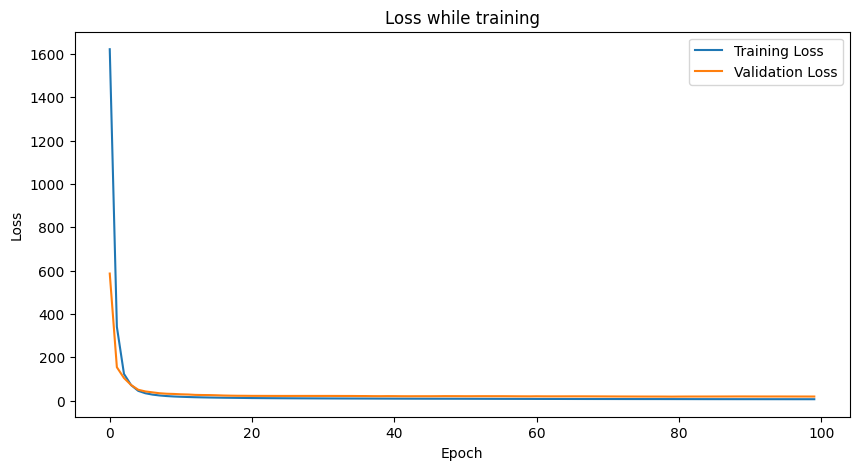

In [13]:
# plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.title("Loss while training")
# plt.xlim([5, num_epochs])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 將圖像保存至檔案
output_path = test_dir['visual'] + "loss_while_training.png"  # 定義保存的檔案名稱和格式
fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
plt.close(fig)  # 避免顯示圖像（若不需要可保留 plt.show()）

### Plot SNR

Training SNR:   26.07174301 dB
Validation SNR: 26.13401413 dB


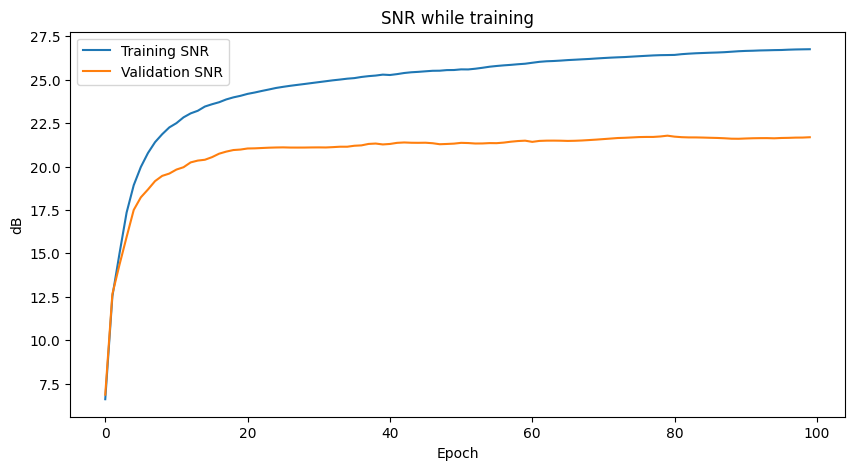

In [14]:
# print the SNR of the first training sample
model.eval()

with torch.no_grad():
    train_output = model(train_input)
    snr = calculate_snr(train_clean, train_output)
    print(f"Training SNR:   {snr:.8f} dB")

with torch.no_grad():
    val_output = model(val_input)
    snr = calculate_snr(val_clean, val_output)
    print(f"Validation SNR: {snr:.8f} dB")
    
# plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(training_snrs, label="Training SNR")
plt.plot(validation_snrs, label="Validation SNR")
plt.title("SNR while training")
plt.xlabel("Epoch")
plt.ylabel("dB")
plt.legend()
plt.show()

# 將圖像保存至檔案
output_path = test_dir['visual'] + "snr_while_training.png"  # 定義保存的檔案名稱和格式
fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
plt.close(fig)  # 避免顯示圖像（若不需要可保留 plt.show()）

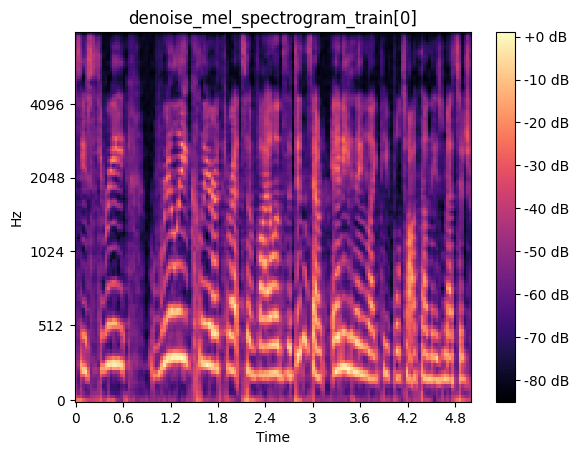

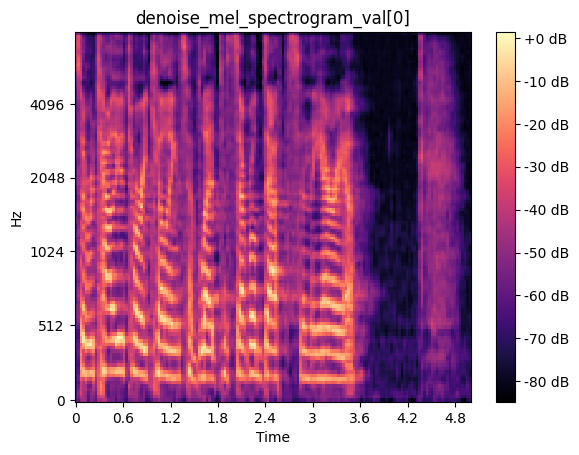

In [15]:
model.eval()

denoised_output = model(torch.from_numpy(mixed_mel_spectrograms_train[0]).unsqueeze(0))
denoised_output = denoised_output[:, :, :, :157]
fig, ax = plt.subplots()
img = librosa.display.specshow(denoised_output.squeeze(0).squeeze(0).detach().numpy(), sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='denoise_mel_spectrogram_train[0]')
plt.show()

# 將圖像保存至檔案
output_path = test_dir['visual'] + "denoise_mel_spectrogram_train[0].png"  # 定義保存的檔案名稱和格式
fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
plt.close(fig)  # 避免顯示圖像 (若不需要可保留 plt.show())

denoised_output = model(torch.from_numpy(mixed_mel_spectrograms_val[0]).unsqueeze(0))
denoised_output = denoised_output[:, :, :, :157]
fig, ax = plt.subplots()
img = librosa.display.specshow(denoised_output.squeeze(0).squeeze(0).detach().numpy(), sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='denoise_mel_spectrogram_val[0]')
plt.show()

# 將圖像保存至檔案
output_path = test_dir['visual'] + "denoise_mel_spectrogram_val[0].png"  # 定義保存的檔案名稱和格式
fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
plt.close(fig)  # 避免顯示圖像 (若不需要可保留 plt.show())

In [16]:
torch.save(model, "general_model.pth") # TODO

### Prediction

In [17]:
# # MelSpectrogram參數 (勿動)
# n_mels = 128                # 保持 Mel 頻譜圖的解析度
# n_fft = 1024                # 提高 FFT 窗口大小以適配更多信號頻率
# hop_length = 512            # 保持 hop_length 為 n_fft 的一半
# win_length = 1024           # 窗口大小與 n_fft 保持一致（或設為 None 使用默認值）
# sample_rate = 16000         # 採樣率保持不變，適合語音處理
# f_max = sample_rate // 2    # 預設為 Nyquist 頻率，即 8000 Hz
# duration = 5                # 音頻時長為 5 秒

In [18]:
# # MIXED
# mixed_waveform, sample_rate = librosa.load('test2.wav', sr=sample_rate)

# # if sr != sample_rate:
# #     mixed_waveform = librosa.resample(mixed_waveform, orig_sr=sr, target_sr=sample_rate)
    
# # cut to fit the duration
# if len(mixed_waveform) > sample_rate * duration:
#     mixed_waveform = mixed_waveform[:sample_rate * duration]

# mixed_mel_spectrogram = librosa.feature.melspectrogram(
#     y=mixed_waveform,
#     sr=sample_rate,
#     n_fft=n_fft,
#     hop_length=hop_length,
#     n_mels=n_mels
# )

# mixed_mel_spectrogram_db = librosa.power_to_db(
#     mixed_mel_spectrogram, 
#     ref=np.max, 
#     amin=1e-10  # 避免log(0)
# )

# # mixed_mel_tensor = torch.tensor(mixed_mel_spectrogram, dtype=torch.float32).squeeze().unsqueeze(0)
# mixed_mel_tensor = torch.tensor(mixed_mel_spectrogram_db, dtype=torch.float32).squeeze().unsqueeze(0)
# # mixed_mel_tensor = torch.tensor(np.load('nature_mixed.npy'), dtype=torch.float32).squeeze().unsqueeze(0)

# mixed_mel = mixed_mel_tensor
# mixed_output = mixed_mel.squeeze(0).squeeze(0).detach().numpy()
# mixed_output = librosa.db_to_power(mixed_output)

# audio_signal = librosa.feature.inverse.mel_to_audio(
#     mixed_output,
#     sr=sample_rate,
#     n_fft=n_fft,
#     hop_length=hop_length,
#     n_iter=512
# )

# audio_signal = audio_signal / np.max(np.abs(audio_signal))


# librosa.display.waveshow(audio_signal, sr=sample_rate)
# soundfile.write('test_librosa_mixed.wav', audio_signal, sample_rate)

In [19]:
# # DENOISED
# model.eval()  # 设置模型为评估模式
# # print(mixed_mel_tensor.shape)
# print(test_mixed_mel_spectrograms[0].shape)
# mixed_mel_np_array = np.array(test_mixed_mel_spectrograms)
# for i in range(len(mixed_mel_np_array)):
#     mixed_mel_np_array[i] = mixed_mel_np_array[i][:, :, :157]
# print(mixed_mel_np_array.shape)

# mixed_mel_tensor = torch.tensor(mixed_mel_np_array, dtype=torch.float32)

# denoised_output = model(mixed_mel_tensor)
# denoised_output = denoised_output[:, :, :, :157]
# print(denoised_output.shape)
# denoised_output = denoised_output.squeeze(0).squeeze(0).detach().numpy()
# denoised_output = librosa.db_to_power(denoised_output)

# audio_signal = librosa.feature.inverse.mel_to_audio(denoised_output, sr=sample_rate, n_iter=500)
# audio_signal = audio_signal / np.max(np.abs(audio_signal))

# librosa.display.waveshow(audio_signal, sr=sample_rate)
# soundfile.write('test_librosa_denoised.wav', audio_signal, sample_rate)
